In [2]:
import os
import numpy as np
import pandas as pd
from joblib import dump

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
)

from sklearn.decomposition import PCA

In [6]:
DATA_PATH = "../app/data/data_sensors.csv"
LABEL_COL = "Label"
OUTDIR = "baseline_outputs"
os.makedirs(OUTDIR, exist_ok=True)

In [7]:

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Model selection
K_MIN, K_MAX = 2, 15
COV_TYPE = "diag"          # EDA-backed
N_INIT = 10 # Tried (15,20 with k 6 same result)
MAX_ITER = 300
REG_COVAR = 1e-6

# Operational gates
CONF_THRESH = 0.85
MIN_SUPPORT = 4
MIN_PURITY = 0.80

# Plots/analytics
CONF_GRID = np.arange(0.55, 0.96, 0.05)
STABILITY_RUNS = 8
CAL_BINS = np.array([0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


In [9]:
df = pd.read_csv(DATA_PATH)
sensor_cols = [c for c in df.columns if c.lower().startswith("sensor")]

X = df[sensor_cols]
y = df[LABEL_COL]
labeled_mask = y.notna()

print(f"Rows={len(df)}, Features={len(sensor_cols)}")
print(f"Labeled={int(labeled_mask.sum())}, Unlabeled={int((~labeled_mask).sum())}")


Rows=1600, Features=20
Labeled=40, Unlabeled=1560


In [12]:
# 1) Preprocess
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
])
Xp = preprocess.fit_transform(X)
Xp

array([[-0.55935362, -0.65618218,  0.6076835 , ...,  0.25533453,
         0.67751302, -0.99720914],
       [ 0.29098014, -0.20576746, -0.50250476, ..., -0.10065216,
         0.93471056,  0.22866634],
       [ 0.6865218 ,  0.40473963,  1.38181366, ..., -0.54610134,
        -0.49913885, -0.23222006],
       ...,
       [ 0.10151186,  0.35305716, -0.74748264, ..., -0.43290751,
         0.11538296,  0.04814491],
       [ 0.74381272,  0.82038376,  0.16436498, ..., -0.40277687,
         0.7254612 , -0.36463878],
       [-0.39512738, -0.18678336,  0.44573472, ...,  0.03103084,
         0.36266721, -0.78976665]], shape=(1600, 20))

In [16]:
best_bic = np.inf
best_gmm = None
rows = []
for k in range(K_MIN, K_MAX+1):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=COV_TYPE,
        init_params="kmeans",
        n_init=N_INIT,
        max_iter=MAX_ITER,
        reg_covar=REG_COVAR,
        random_state=RANDOM_SEED,
    ).fit(Xp)

    bic = gmm.bic(Xp)
    aic = gmm.aic(Xp)
    rows.append({"k": k, "bic": bic, "aic": aic})
    if bic < best_bic:
        best_bic = bic
        best_gmm = gmm
sel = pd.DataFrame(rows)
sel.to_csv(os.path.join(OUTDIR, "model_selection_bic_aic.csv"), index=False)
K = int(best_gmm.n_components)
print("Selected K:", K)

Selected K: 6


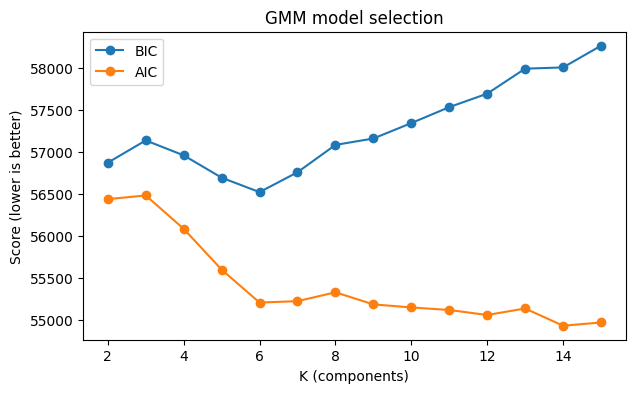

In [19]:
plt.figure(figsize=(7,4))
plt.plot(sel["k"], sel["bic"], marker="o", label="BIC")
plt.plot(sel["k"], sel["aic"], marker="o", label="AIC")
plt.xlabel("K (components)")
plt.ylabel("Score (lower is better)")
plt.title("GMM model selection")
plt.legend()
plt.show()